[*********************100%***********************]  1 of 1 completed


         Current function value: 564.278584
         Iterations: 4
         Function evaluations: 155
         Gradient evaluations: 24


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


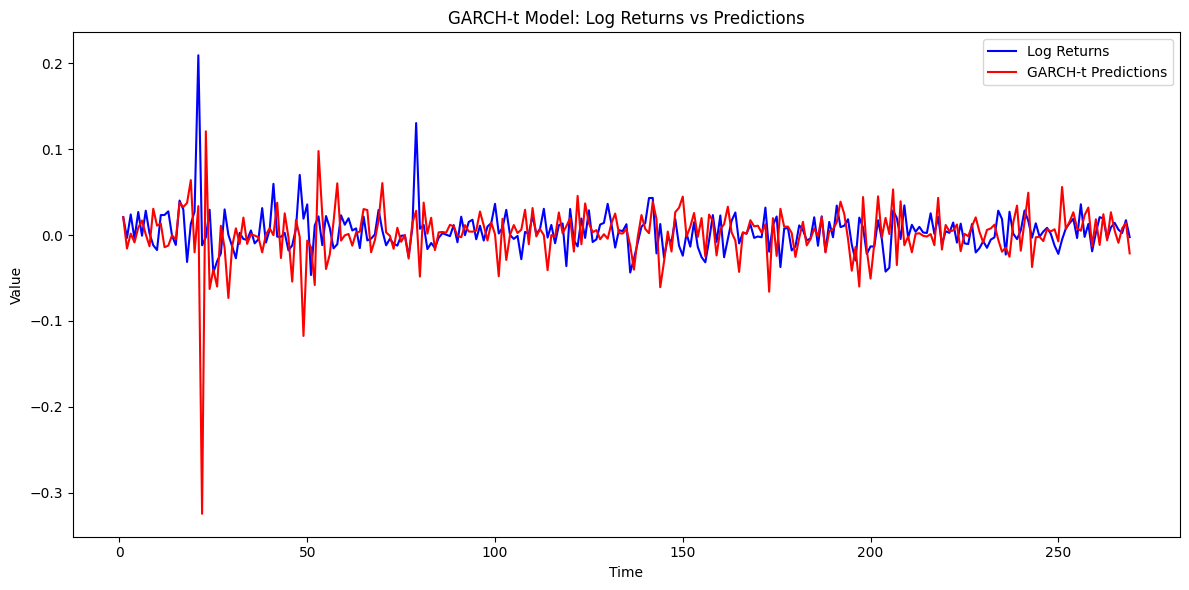

RMSE value is: 4.02%


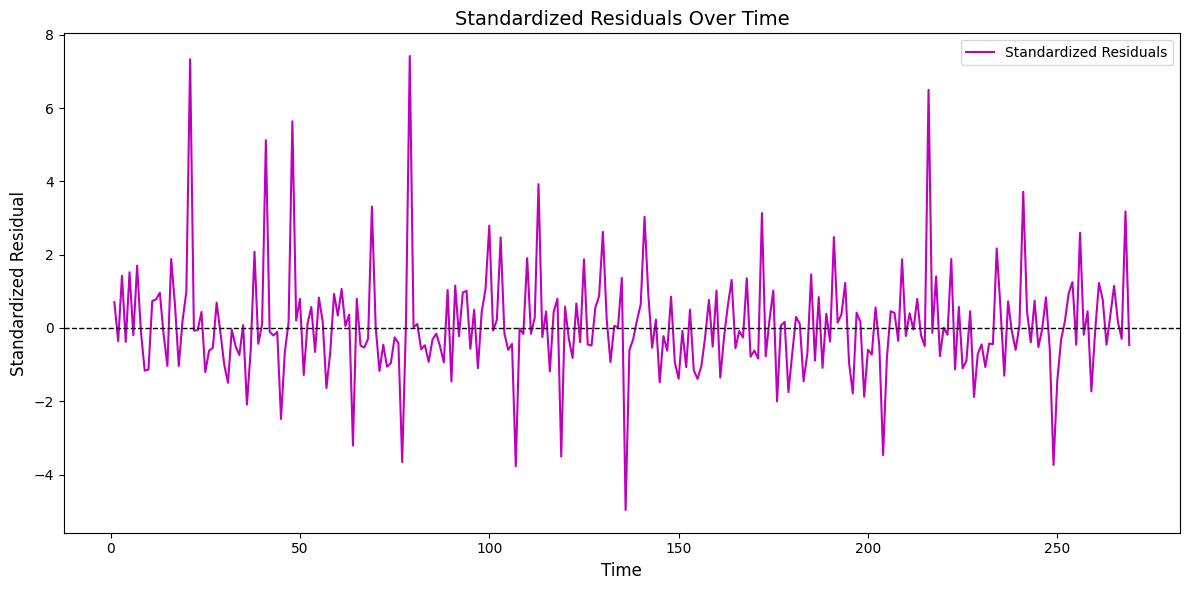

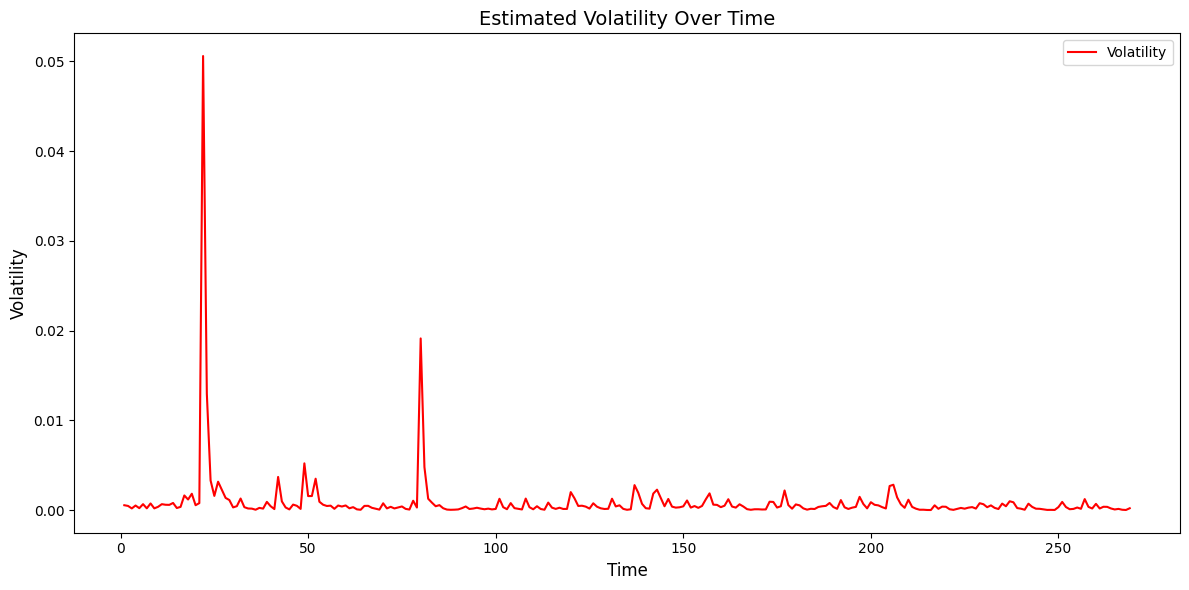


ARCH-t Model Parameters:
Mu (Mean): 0.0043
Omega (Variance Constant): 0.0000
Alpha (ARCH Effect): 1.2000
Beta (GARCH Effect): 0.2500
Nu (Degree of Freedom): 10.0000

Summary Statistics for Log Returns:
       Log Returns
count   269.000000
mean      0.004332
std       0.023401
min      -0.046546
25%      -0.008727
50%       0.002103
75%       0.014972
max       0.209307


In [ ]:
import numpy as np
import pandas as pd
import scipy.special as ss
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf

# Set a random seed for reproducibility
np.random.seed(10)


def garch(param, *args):
    # Initialize Params
    mu = param[0]
    omega = param[1]
    alpha = param[2]
    beta = param[3]
    nv = param[4]
    GARCH_Dens, sigma2, F, v = {}, {}, {}, {}
    # Initialize values
    sigma2[0] = np.var(Y)
    Likelihood = 0
    for t in range(1, T):
        sigma2[t] = omega + alpha * ((Y[t - 1] - mu) ** 2) + beta * (sigma2[t - 1])
        if sigma2[t] < 0:
            sigma2[t] = 1e-2
        F[t] = Y[t] - mu - np.sqrt(sigma2[t]) * np.random.standard_t(nv, 1)
        v[t] = sigma2[t]
        GARCH_Dens[t] = (
            np.log(ss.gamma((nv + 1) / 2))
            - np.log(np.sqrt(nv * np.pi))
            - np.log(ss.gamma(nv / 2))
            - ((nv + 1) / 2) * np.log(1 + ((F[t] ** 2) / v[t]) / nv)
        )
        Likelihood += GARCH_Dens[t]

    return -Likelihood


def garch_path(params, *args):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    nv = params[4]
    sigma2, path = {}, {}
    # Initialize volatility and path
    sigma2[0] = np.var(Y)
    path[0] = np.array([Y[0]])
    for t in range(1, T):
        sigma2[t] = omega + alpha * ((Y[t - 1] - mu) ** 2) + beta * (sigma2[t - 1])
        if sigma2[t] < 0:
            sigma2[t] = 1e-2
        path[t] = mu + np.sqrt(sigma2[t]) * np.random.standard_t(nv, 1)

    return path, sigma2


# Fetch the META stock data
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 1, 31)
stock_symbol = "META"
stock = yf.download(stock_symbol, start_date, end_date)

# Calculate log returns
Y = np.diff(np.log(stock["Close"].values))
T = Y.shape[0]

# Initial parameter estimates
param0 = np.array([np.mean(Y), np.var(Y) / 2500, 1.2, 0.25, 10])

# Minimize the GARCH-t model
results = minimize(garch, param0, method="BFGS", tol=1e-2, options={"disp": True})
param_star = results.x

# Generate the GARCH path
path, vol = garch_path(param_star, Y, T)
Y_GARCH = list(path.values())
timevec = np.linspace(1, T, T)

# Plot log returns and GARCH path
plt.figure(figsize=(12, 6))
plt.plot(timevec, Y, "b", label="Log Returns")
plt.plot(timevec, Y_GARCH, "r", label="GARCH-t Predictions")
plt.title("GARCH-t Model: Log Returns vs Predictions")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE
GARCH_prediction = np.array(Y_GARCH)
RMSE = np.sqrt(np.mean((GARCH_prediction - Y) ** 2))
print(f"RMSE value is: {RMSE * 100:.2f}%")

# Standardized residuals
standardized_residuals = (Y - np.array([param_star[0]] * T)) / np.sqrt(
    list(vol.values())
)

# Plot standardized residuals
plt.figure(figsize=(12, 6))
plt.plot(timevec, standardized_residuals, "m", label="Standardized Residuals")
plt.axhline(y=0, color="black", linestyle="--", linewidth=1)
plt.title("Standardized Residuals Over Time", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Standardized Residual", fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.tight_layout()
plt.show()

# Plot the volatility
plt.figure(figsize=(12, 6))
plt.plot(timevec, list(vol.values()), "r", label="Volatility")
plt.title("Estimated Volatility Over Time", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Volatility", fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.tight_layout()
plt.show()

# Print ARCH-t Model Parameters
print("\nARCH-t Model Parameters:")
print(f"Mu (Mean): {param_star[0]:.4f}")
print(f"Omega (Variance Constant): {param_star[1]:.4f}")
print(f"Alpha (ARCH Effect): {param_star[2]:.4f}")
print(f"Beta (GARCH Effect): {param_star[3]:.4f}")
print(f"Nu (Degree of Freedom): {param_star[4]:.4f}")

# Summary Statistics
print("\nSummary Statistics for Log Returns:")
log_returns_df = pd.DataFrame(Y, columns=["Log Returns"])
summary_stats = log_returns_df.describe()
print(summary_stats)
